# Free Diving in Food Facts

The [dataset](https://world.openfoodfacts.org/data) presents many [fields](https://static.openfoodfacts.org/data/data-fields.txt) for each product. 

In [182]:
import re
import pickle
import importlib # reload an imported module 
import time
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from importlib import reload 
from IPython.display import clear_output

In [150]:
import lucas_utils as lu
# Once the script is imported, calling import will not reload the script if it is modified 
lu = importlib.reload(lu)

In [27]:
# define some constants
DATASET_PATH = 'data/en.openfoodfacts.org.products.csv'
ENCODING = 'UTF-8'
PICKLE_DATASET_PATH = 'data/en.openfoodfacts.org.products.pickle'

In [19]:
# Pickle utilities
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def save_pickle(result, file_path = 'pickle'):
    with open(file_path, 'wb') as file:
        pickle.dump(result, file)

**Load the data:**

---
---
Load the whole dataset from the `.csv` file (takes a minute):

In [ ]:
food_facts_df = pd.read_csv(DATASET_PATH, encoding=ENCODING, sep='\t',low_memory=False)

In [ ]:
# Save the dataframe with pickle for faster loading
save_pickle(food_facts_df, PICKLE_DATASET_PATH)

---
Or use pickle instead to load the dataframe directly:

In [20]:
food_facts_df = load_pickle(PICKLE_DATASET_PATH)

---
---

In [90]:
print('The dataset contains ',len(food_facts_df),' entries.')

The dataset contains  1030905  entries.


**Use a sample of the dataset**

Use only a sample containing 10'000 products for experimenting:

In [21]:
sample_df = food_facts_df.head(10000).copy()

In [22]:
sample_df.head(2)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Question: What are the levels of interdependencies between nations based on their production and importations?

Let us first identify the [fields](https://static.openfoodfacts.org/data/data-fields.txt) that are relevant to the question:

In [36]:
FIELDS = ['origins',
          'origins_tags',
          'manufacturing_places',
          'manufacturing_places_tags',
          'first_packaging_code_geo',
          'cities',
          'cities_tags',
          'purchase_places',
          'stores',
          'countries',
          'countries_tags']
# 'countries_fr' generates a key error

Let us observe the type of information each of them offers: 

In [78]:
for field in FIELDS:
    print('Field: ' + field)
    print('\t',lu.get_field_without_nan(sample_df,field).head(4).values)

Field: origins
	 ['France' 'Québec' 'Québec' 'France']
Field: origins_tags
	 ['france' 'quebec' 'quebec' 'france']
Field: manufacturing_places
	 ['France' 'France' 'Brossard Québec' 'Brossard Québec']
Field: manufacturing_places_tags
	 ['france' 'france' 'brossard-quebec' 'brossard-quebec']
Field: first_packaging_code_geo
	 ['47.833333,-0.333333' '47.883333,-2.766667' '49.083333,2.75'
 '47.7,-0.366667']
Field: cities
	 []
Field: cities_tags
	 ['sable-sur-sarthe-sarthe-france' 'bignan-morbihan-france'
 'lagny-le-sec-oise-france' 'daumeray-maine-et-loire-france']
Field: purchase_places
	 ['France' 'Roissy,France' 'Roissy,France' 'France']
Field: stores
	 ['courte paille' 'Marks & Spencer' 'Marks & Spencer' "Sainsbury's"]
Field: countries
	 ['France' 'France' 'France' 'en:France']
Field: countries_tags
	 ['en:france' 'en:france' 'en:france' 'en:france']


An important criterion to select reliable fields is how complete the information is per field:

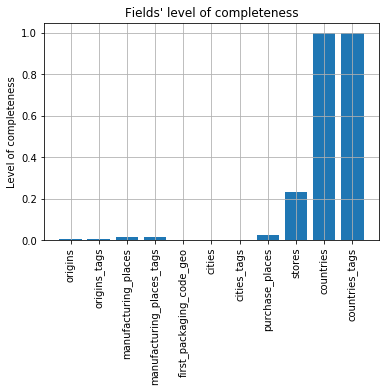

In [83]:
# Levels for the dataset sample
lu.show_fields_completeness(sample_df,FIELDS,verbose=True)

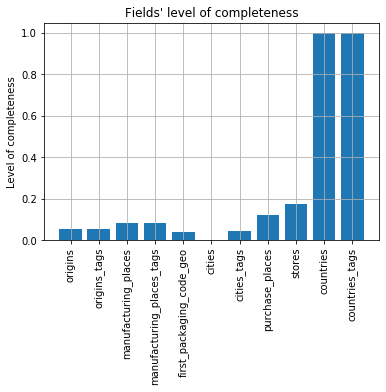

In [84]:
# Levels for the full dataset
lu.show_fields_completeness(food_facts_df,FIELDS,verbose=True)

Clearly, the most reliable fields are `countries` and `countries_tags` since they are almost missing no data! Furthermore, `countries_tags` is essentially a cleaned up version of `countries`. We will therefore definitely use this field. It indicates where the product is sold.

Let us analyze this field more in depth. Let us see what `unique()` returns for this field:

In [100]:
# Store unique 'countries_tag' 
unique_countries_tag_s = pd.Series(sample_df['countries_tags'].dropna().unique())

In [103]:
unique_countries_tag_s.head(6)

0                     en:france
1              en:united-states
2                    en:ireland
3                    en:belgium
4             en:united-kingdom
5    en:france,en:united-states
dtype: object

The data seems to be clean! Some products exist in different countries. When this is the case, the `countries_tag` field contains a list of countries separated by commas. To really identify unique countries the dataframe should be modified to list a single country per product. In this way, we will exactly know what countries are present and how many products are found in each of them.

To do so, we need to explode the `countries_tags` to contain a single value instead of a list of countries. This will create a new row which is a duplicate of the original one where the `countries_tags` field contains a single value. 

In [194]:
unique_countries_s = lu.get_unique_values_of_field(food_facts_df,field='countries_tags')

In [195]:
# Store the countries in a text file
with open('data/countries.txt','wb') as file: 
    for i,country in enumerate(unique_countries_s):
        file.write((country+'\n').encode('utf8'))